# LSTM model full hour

Libraries import

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error, mean_absolute_error

CSV file reading

In [31]:
# Read the CSV file
all_data = pd.read_csv("excel_data/data_ready_for_training.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
all_data = all_data[["relh", "skph", "temp", "minutes"]]

In [32]:
all_data.head()

,relh,skph,temp,minutes
0,100.0,0.000,-2.0,0
1,100.0,0.000,-2.0,30
2,100.0,3.704,-2.0,0
3,100.0,0.000,-2.0,30
4,100.0,5.556,-3.0,0


In [33]:
# only full hours
all_data = all_data[all_data['minutes'] == 0]
all_data.drop('minutes',axis='columns', inplace=True)

Tranformation and split data

In [34]:
# GLOBAL
training_mean = []
training_std = []

In [35]:
def standard_score(X, y, index, training_mean, training_std, timestamps_count = 0):
    X[:, :, index] = (X[:, :, index] - training_mean) / training_std
    y[:, index] = (y[:, index] - training_mean) / training_std


def transform_and_split_data(df_input, window_size = 6, test_size = 0.1,  valid_size = 0.1, timestamps_count = 0):
    df = df_input.to_numpy()
    features_len = df_input.shape[1]
    data_count = len(df)
    X = []
    y = []
    # Explanatory X and Response y variables 
    for i in range(data_count-window_size - timestamps_count):
        row = [r for r in df[i:i+window_size]]
        X.append(row)
        label = [df[i+window_size + timestamps_count]]
        y.append(label)
    X = np.array(X)
    y = np.array(y)

    resh0 = y.shape[0]
    resh1 = y.shape[2]
    y = y.reshape(resh0, resh1)
    # data split
    train_size = 1 - test_size - valid_size
    train_last_el = int(data_count * train_size)
    valid_last_el = train_last_el + int(data_count * valid_size)

    X_train, y_train = X[:train_last_el], y[:train_last_el]

    X_val, y_val = X[train_last_el:valid_last_el], y[train_last_el:valid_last_el]
    X_test, y_test = X[valid_last_el:], y[valid_last_el:]

    training_mean = []
    training_std = []
    # data normalization
    for i in range(features_len):
        training_mean.append(np.mean(X[:, :, i]))
        training_std.append(np.std(X[:, :, i]))
        standard_score(X_train, y_train, i, training_mean[i], training_std[i])
        standard_score(X_val, y_val, i, training_mean[i], training_std[i])
        standard_score(X_test, y_test, i, training_mean[i], training_std[i])

    return  X_train, y_train, X_val, y_val, X_test, y_test, training_mean, training_std

LSTM model init, learn and save

In [36]:
# neural network model
def LSTM_model(X_train, y_train, X_val, y_val, epochs =10, learning_rate=0.001, window_size = 6, batch_size = 32):
    model = Sequential()
    model.add(InputLayer((window_size, 3)))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, 'ReLU')) # previous was ReLU
    model.add(Dense(3, 'linear'))
    # model = Sequential()
    # model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 3)))
    # model.add(LSTM(16, 'ReLU')) # previous was ReLU
    # model.add(Dense(32, 'ReLU')) # previous was ReLU
    # model.add(Dense(3, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate= learning_rate), metrics=[RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = batch_size)
    return model

Make predicitions and plot output

In [37]:
def denormalization(y, training_mean, training_std):
  y = (y*training_std) + training_mean
  return y

def make_predictions(model, X, y,  training_mean, training_std):
  predictions = model.predict(X)
  
  features_len = y.shape[1]
  pred = []
  actual =[]

  for i in range(features_len):
    pred.append(denormalization(predictions[:,i], training_mean[i], training_std[i]))
    actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))

  return pred, actual

def plot_predictions_and_actual(pred, actual, start=24, end=48):

  fig, axs = plt.subplots(4)
  fig.suptitle('Weather parameters - red means predicted')
  fig.tight_layout(pad=1.8)
  axs[0].plot(pred[0][start:end],'r')
  axs[0].plot(actual[0][start:end])
  axs[0].set_title('relative humidity')

  axs[1].plot(pred[1][start:end],'r')
  axs[1].plot(actual[1][start:end])
  axs[1].set_title('speed of wind')

  axs[2].plot(pred[2][start:end],'r')
  axs[2].plot(actual[2][start:end])
  axs[2].set_title('temperature')

  axs[3].plot(actual[2][:])
  axs[3].set_title('temperature')

MSE calculations for given window size and etc. for the next 1 to 5 hours

In [38]:
def return_time(window_size,test_size,valid_size,epochs,learning_rate, save_model = False):
    
    MSE_humid = []
    MAE_humid = []

    MSE_wind = []
    MAE_wind = []
    
    MSE_temp = []
    MAE_temp = []

    # MSE calculations for given window size and etc. in next 1 to 3 next hours
    # last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
    last_pred_hour = 12
    for hour in range(last_pred_hour):
        # (hour == 1) it means that predictions will be made for next one hour
        X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std = transform_and_split_data(all_data.copy(), window_size, test_size, valid_size, hour-1) # (hour - 1) it is not mistake
        X_test.size
        model = LSTM_model(X_train, y_train, X_val, y_val, epochs, learning_rate, window_size)

        ## save as binary file .pkl
        if(save_model):
            file_name = "lstm_" + str(hour+1) + ".pkl"
            with open(file_name, "xb") as f_1:
                pickle.dump(model, f_1, -1)

        pred, actaul = make_predictions(model, X_test, y_test,  training_mean, training_std)
        MSE_humid.append(mean_squared_error(actaul[0], pred[0]))
        MAE_humid.append(mean_absolute_error(actaul[0], pred[0]))
        MSE_wind.append(mean_squared_error(actaul[1], pred[1]))
        MAE_wind.append(mean_absolute_error(actaul[1], pred[1]))
        MSE_temp.append(mean_squared_error(actaul[2], pred[2]))
        MAE_temp.append(mean_absolute_error(actaul[2], pred[2]))


    return MSE_humid, MAE_humid, MSE_wind, MAE_wind, MSE_temp, MAE_temp, pred, actaul

In [39]:
test_size = 0.15
valid_size = 0.15
epochs = 12
learning_rate=0.001

window_size = 2
MSE_humid_2, MAE_humid_2, MSE_wind_2, MAE_wind_2, MSE_temp_2, MAE_temp_2, pred_2, actaul_2  = return_time(window_size,test_size,valid_size,epochs,learning_rate)
window_size = 4
MSE_humid_4, MAE_humid_4, MSE_wind_4, MAE_wind_4, MSE_temp_4, MAE_temp_4, pred_4, actaul_4  = return_time(window_size,test_size,valid_size,epochs,learning_rate)
window_size = 6
MSE_humid_6, MAE_humid_6, MSE_wind_6, MAE_wind_6, MSE_temp_6, MAE_temp_6, pred_6, actaul_6  = return_time(window_size,test_size,valid_size,epochs,learning_rate)
window_size = 8
MSE_humid_8, MAE_humid_8, MSE_wind_8, MAE_wind_8, MSE_temp_8, MAE_temp_8, pred_8, actaul_8  = return_time(window_size,test_size,valid_size,epochs,learning_rate)
window_size = 10
MSE_humid_10, MAE_humid_10, MSE_wind_10, MAE_wind_10, MSE_temp_10, MAE_temp_10, pred_10, actaul_10  = return_time(window_size,test_size,valid_size,epochs,learning_rate)
window_size = 12
MSE_humid_12, MAE_humid_12, MSE_wind_12, MAE_wind_12, MSE_temp_12, MAE_temp_12, pred_12, actaul_12  = return_time(window_size,test_size,valid_size,epochs,learning_rate)

Epoch 1/12
1577/1577 [==============================] - 8s 4ms/step - loss: 0.0503 - root_mean_squared_error: 0.2243 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 2/12
1577/1577 [==============================] - 6s 4ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 3/12
1577/1577 [==============================] - 5s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 4/12
1577/1577 [==============================] - 5s 3ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 5/12
1577/1577 [==============================] - 5s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 8.3517e-04 - val_root_mean_squared_error: 0.0289
Epoch 6/12
1577/1577 [==============================] - 5s 3ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_los

In [45]:
print(MAE_humid_2)
print(MAE_wind_2)
print(MAE_temp_2)

print(MAE_humid_4)
print(MAE_wind_4)
print(MAE_temp_4)

print(MAE_humid_6)
print(MAE_wind_6)
print(MAE_temp_6)

print(MAE_humid_8)
print(MAE_wind_8)
print(MAE_temp_8)


print(MAE_humid_10)
print(MAE_wind_10)
print(MAE_temp_10)

print(MAE_humid_12)
print(MAE_wind_12)
print(MAE_temp_12)

[0.7042311904507795, 3.913259065315748, 5.694723208276821, 7.4987239562768035, 8.957408816599765, 10.675634359938336, 11.777716045148392, 12.685558990667769, 13.428128901478715, 14.156905163498504, 14.326302501832807, 14.617615387415006]
[0.16183810143298308, 2.783921101449972, 3.472802740296622, 4.073719412577407, 4.548549450269049, 4.970736844216191, 5.307177972914851, 5.580535024077307, 5.715857236855297, 5.846071684621392, 5.893308108207662, 6.005782518405208]
[0.43303598853465797, 0.7662776389902769, 1.1860499967863938, 1.5913485361416193, 2.003378916550071, 2.369564642889421, 2.6531651056458254, 2.927921253369941, 3.0471387343374454, 3.255663910920345, 3.2842486338001327, 3.378657352703589]
[1.205143463081122, 3.8539776153197383, 5.565320127544895, 7.191388260048671, 8.940339292809567, 10.23606751835642, 11.671707569345834, 12.366185189472969, 13.078457691866143, 13.498770026185777, 13.788777743767936, 13.888093173526398]
[0.3431765037693317, 2.7435595184519586, 3.536281136440835

Text(0, 0.5, 'MSE')

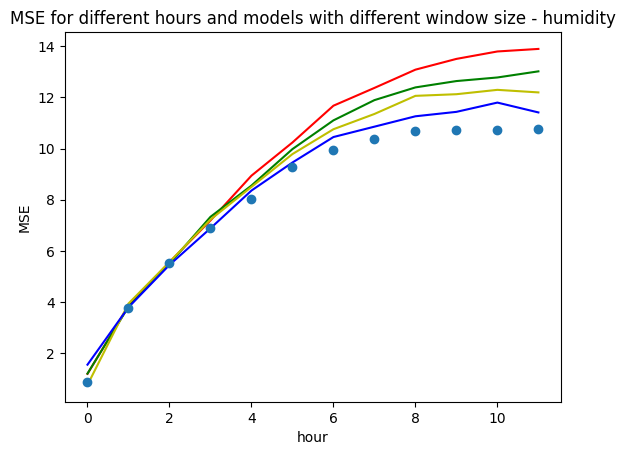

In [61]:
# remember! the first is useless
plt.plot(MAE_humid_4,'r')#,MAE_humid_4,MAE_humid_6,MAE_humid_8,MAE_humid_10, MAE_humid_12])
plt.plot(MAE_humid_6,'g')
plt.plot(MAE_humid_8,'y')
plt.plot(MAE_humid_10,'b')
plt.plot(MAE_humid_12,'o')
plt.title("MSE for different hours and models with different window size - humidity")
plt.xlabel("hour")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

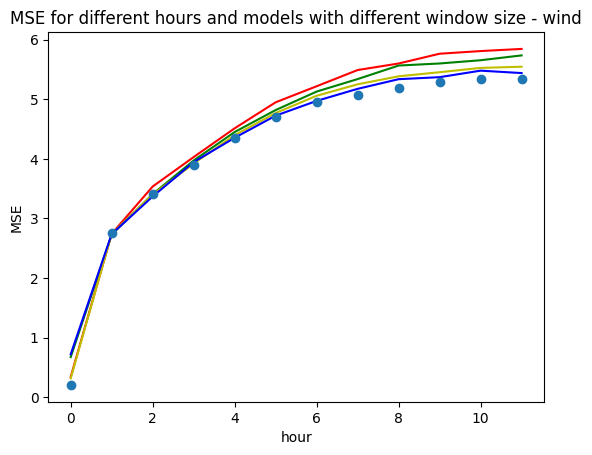

In [62]:
# remember! the first is useless
plt.plot(MAE_wind_4,'r')#,MAE_humid_4,MAE_humid_6,MAE_humid_8,MAE_humid_10, MAE_humid_12])
plt.plot(MAE_wind_6,'g')
plt.plot(MAE_wind_8,'y')
plt.plot(MAE_wind_10,'b')
plt.plot(MAE_wind_12,'o')
plt.title("MSE for different hours and models with different window size - wind")
plt.xlabel("hour")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

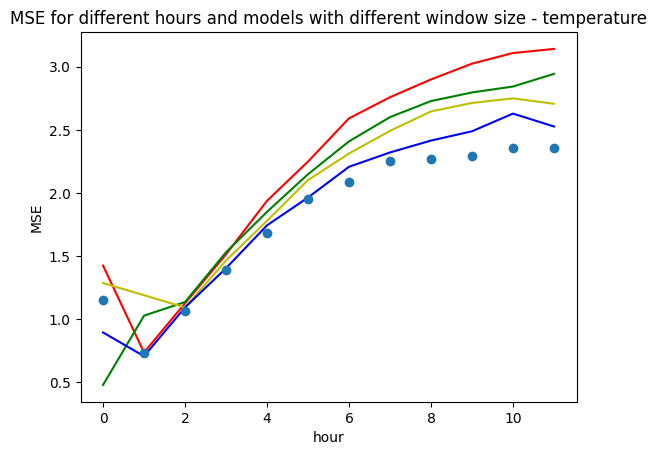

In [63]:
# remember! the first is useless
plt.plot(MAE_temp_4,'r')#,MAE_humid_4,MAE_humid_6,MAE_humid_8,MAE_humid_10, MAE_humid_12])
plt.plot(MAE_temp_6,'g')
plt.plot(MAE_temp_8,'y')
plt.plot(MAE_temp_10,'b')
plt.plot(MAE_temp_12,'o')
plt.title("MSE for different hours and models with different window size - temperature")
plt.xlabel("hour")
plt.ylabel("MSE")

# Attention! My mistake - predictions are for the next 11 hours, but the first one is for the exact hour